# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [28]:
!pip freeze > requirements.txt

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.0 MB/s eta 0:00:00
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6296 sha256=a05bae5a75ed3480751870fad618963896310de1eab4e3b1ab841bc657f8a04d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
#!find dogImages/. -type f | wc -l
!ls dogImages/valid -l | wc -l
!find dogImages/train/. -type f | wc -l

--2024-04-02 11:27:29--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.0, 52.219.120.120, 52.219.120.240, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

100%[====================================>] 1,132,023,110 25.0MB/s   in 58s    

2024-04-02 11:28:28 (18.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  

In [4]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/cd0387-project-resnet-50"

role = sagemaker.get_execution_role()

In [5]:
# TODO: Upload the data to an S3 bucket. You can use the sagemaker_session object, boto3 or the AWS CLI
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50


In [6]:
!pip install torchvision

In [7]:
import torchvision
import torch
from torchvision import datasets, models, transforms
import os

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './dogImages'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
print(class_names)

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Cardigan_welsh_

In [9]:
print(dataset_sizes)
print(class_names)

{'train': 6680, 'valid': 835}
['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Can

In [10]:
print(image_datasets)
print(dataloaders)
print(len(class_names))

{'train': Dataset ImageFolder
    Number of datapoints: 6680
    Root location: ./dogImages/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'valid': Dataset ImageFolder
    Number of datapoints: 835
    Root location: ./dogImages/valid
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f19e59e5ed0>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7f19e59e5f00>}
133


Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([36,  5, 96, 14])


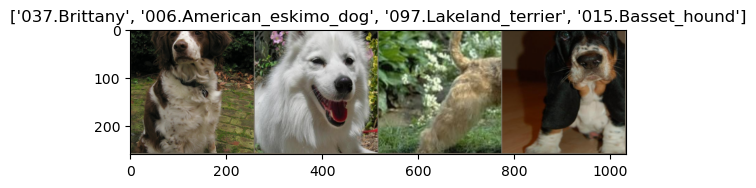

In [11]:
import numpy as np
import matplotlib.pyplot as plt

#show images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [12]:
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput

In [13]:
#!pip install amazon-ai-s3-data-loader

ERROR: Could not find a version that satisfies the requirement amazon-ai-s3-data-loader (from versions: none)
ERROR: No matching distribution found for amazon-ai-s3-data-loader


In [13]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameters = {
    #"gpu": True,
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([8, 16, 32, 64, 128]),
    "epochs": IntegerParameter(2, 10),
    #"model": "resnet50",
}

In [14]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [65]:
#TODO: Create estimators for your HPs
s3_data_path = 's3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/'
s3_model_path = 's3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/model'
s3_output_path = 's3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/output'

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    source_dir="scripts",
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    output_path = s3_output_path,
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameters,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
) #TODO: Create your HyperparameterTuner Object# TODO: Your HP tuner here

In [63]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/cd0387-project-resnet-50"

role = sagemaker.get_execution_role()

print(bucket)
print(prefix)

sagemaker-us-east-1-733710257842
sagemaker/cd0387-project-resnet-50


In [23]:
train_data_loc = 's3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50'
#val_data_loc = 's3://sagemaker-us-east-1-433073421675/sagemaker/cd0387-project-resnet-50/valid'
#test_data_loc = 's3://sagemaker-us-east-1-433073421675/sagemaker/cd0387-project-resnet-50/test'

channels = {
    'training': train_data_loc,
    #'validation': val_data_loc,
    #'test': test_data_loc
}

In [66]:
# TODO: Fit your HP Tuner
tuner.fit(inputs=channels, wait=True) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-240402-1423


..............................................................................................................................................................................................................!


In [67]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-04-02 14:32:57 Starting - Preparing the instances for training
2024-04-02 14:32:57 Downloading - Downloading the training image
2024-04-02 14:32:57 Training - Training image download completed. Training in progress.
2024-04-02 14:32:57 Uploading - Uploading generated training model
2024-04-02 14:32:57 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '2',
 'lr': '0.0016043438272720638',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-04-02-14-23-29-860"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-733710257842/pytorch-training-2024-04-02-14-23-29-860/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [26]:
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile
#from smdebug.trials import create_trial
#from smdebug.core.modes import ModeKeys

In [27]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=5)
)
collection_config = [CollectionConfig(
    name="CrossEntropyLoss_output_0", 
    parameters={
        "include_regex": "CrossEntropyLoss_output_0",
        "train.save_interval": "5", 
        "eval.save_interval": "1"})]
    
debugger_config = DebuggerHookConfig(
    collection_configs=collection_config
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [68]:
# TODO: Create and fit an estimator
#best_hyperparameters = {'batch_size': 256, 'epochs': 6, 'lr': 0.0012003609534198224 }
best_hyperparameters = {'batch_size': 32, 'epochs': 2, 'lr': 0.0016043438272720638 }


estimator = PyTorch(
    entry_point="train_model.py",
    source_dir="scripts",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    output_path = s3_output_path,
    hyperparameters = best_hyperparameters,
    profiler_config = profiler_config, 
    debugger_hook_config = debugger_config, 
    rules = rules 
)

In [69]:
estimator.fit({'training': train_data_loc}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-04-02-14-42-09-375


2024-04-02 14:42:09 Starting - Starting the training job...
2024-04-02 14:42:24 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-04-02 14:43:01 Downloading - Downloading input data...............
2024-04-02 14:45:23 Downloading - Downloading the training image............
2024-04-02 14:47:42 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-04-02 14:47:38,683 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-04-02 14:47:38,718 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-04-02 14:47:38,722 sagemaker_pytorch_container.training INFO     Invoking user training 

In [70]:
path = estimator.latest_job_debugger_artifacts_path()
print(path)

s3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/output/pytorch-training-2024-04-02-14-42-09-375/debug-output


In [72]:
!pip install smdebug

In [71]:
import smdebug.trials as smd
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt

path = estimator.latest_job_debugger_artifacts_path()
#path = "s3://sagemaker-us-east-1-433073421675/sagemaker/cd0387-project-resnet-50/output/pytorch-training-2024-03-31-16-43-47-880/debug-output"
trial = smd.create_trial(path=path)
print(f"Saved these tensors: {trial.tensor_names()}")
#print(f"Loss values during evaluation were {trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.TRAIN)}")



[2024-04-02 14:51:56.837 ip-172-16-135-166.ec2.internal:9557 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/output/pytorch-training-2024-04-02-14-42-09-375/debug-output
[2024-04-02 14:51:57.096 ip-172-16-135-166.ec2.internal:9557 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 234 more expected)', IncompleteRead(0 bytes read, 234 more expected)) while reading s3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/output/pytorch-training-2024-04-02-14-42-09-375/debug-output/index/000000000/000000000110_worker_0.json . Will retry now
[2024-04-02 14:51:59.292 ip-172-16-135-166.ec2.internal:9557 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-04-02 14:52:00.310 ip-172-16-135-166.ec2.internal:9557 INFO trial.py:210] Loaded all steps
Saved these tensors

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

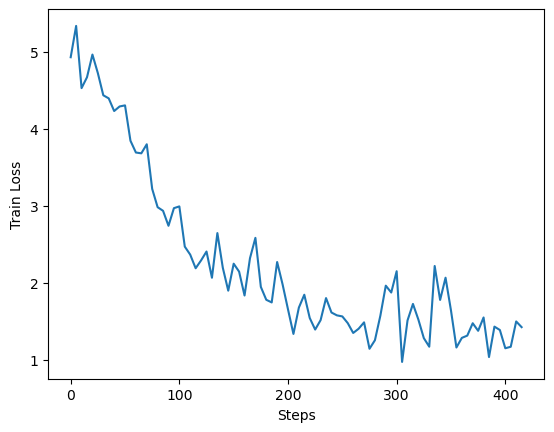

In [73]:
# TODO: Display the profiler output
plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=ModeKeys.TRAIN),list(trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.TRAIN).values()))
plt.show()

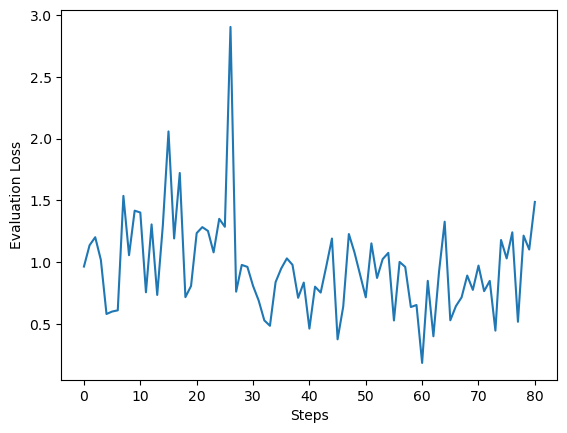

In [74]:
plt.ylabel('Evaluation Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=ModeKeys.EVAL),list(trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.EVAL).values()))
plt.show()

In [75]:
import smdebug
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

# Specify the training job name
training_job_name = estimator.latest_training_job.job_name
region = "us-east-1"
# Load the training job data
tj = TrainingJob(training_job_name, region)



ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/output', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 5, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 5, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 5, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 5, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 5, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/output/pytorch-training-2024-04-02-14-42-09-375/profiler-output


In [76]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [77]:
#rule_output_path = "s3://sagemaker-us-east-1-433073421675/sagemaker/cd0387-project-resnet-50/output/pytorch-training-2024-03-31-16-43-47-880/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive

You will find the profiler report in s3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/outputpytorch-training-2024-04-02-14-42-09-375/rule-output


In [78]:
! aws s3 cp {rule_output_path} ./ --recursive

In [79]:
import IPython

IPython.display.HTML(filename="ProfilerReport/profiler-output/profiler-report.html")

## Model Deploying

In [93]:
# TODO: Deploy your model to an endpoint

from sagemaker.pytorch import PyTorchModel

# Create a PyTorchModel object
pytorch_model = PyTorchModel(
    model_data=estimator.model_data,  # This is the S3 location of your trained model
    role=role,                        # Your IAM role with the necessary permissions
    source_dir="scripts",
    entry_point='inference.py',       # Your entry point file (inference script)
    framework_version='1.8.0',        # PyTorch framework version used
    py_version='py3',                 # Python version
)

# predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

In [92]:
print(estimator.model_data)

s3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/output/pytorch-training-2024-04-02-14-42-09-375/output/model.tar.gz


In [ ]:
# Deploy the model
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-733710257842/sagemaker/cd0387-project-resnet-50/output/pytorch-training-2024-04-02-14-42-09-375/output/model.tar.gz), script artifact (scripts), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-733710257842/pytorch-inference-2024-04-02-16-24-07-204/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-04-02-16-24-11-765
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-04-02-16-24-12-490
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-04-02-16-24-12-490


------

Display Image class 101:


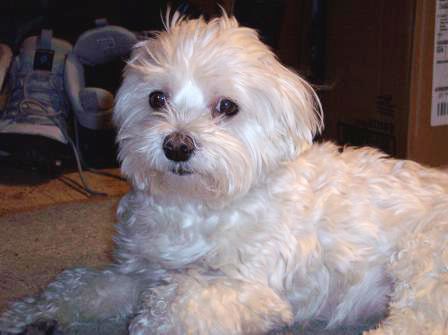

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2024-04-02-15-49-59-278 in account 733710257842 for more information.

In [86]:
# TODO: Run an prediction on the endpoint
from PIL import Image
import io

test_image_path = "./dogImages/test/101.Maltese/Maltese_06716.jpg"

with open(test_image_path, "rb") as f:
    payload = f.read()
    print("Display Image class 101:")
    display(Image.open(io.BytesIO(payload)))

response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
predicted_dog_breed = np.argmax(response, 1) + 1

print(f"Prediction: {predicted_dog_breed}")


#image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
#response = predictor.predict(image)

In [91]:
import boto3

# Create a SageMaker client
sagemaker = boto3.client('sagemaker')

# List endpoints and sort by creation time
response = sagemaker.list_endpoints(SortBy='CreationTime', SortOrder='Descending')

# Assume you want the most recently created endpoint, you can adjust the logic here as needed
latest_endpoint = response['Endpoints'][0]['EndpointName']

# Now you can use the latest endpoint name in the invoke_endpoint call
runtime = boto3.client('sagemaker-runtime')

response = runtime.invoke_endpoint(
    EndpointName=latest_endpoint,
    ContentType='application/x-image',
    Body=payload  # the image bytes you obtained from the requests.get call
)

print(response)

ReadTimeoutError: Read timeout on endpoint URL: "https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/pytorch-inference-2024-04-02-16-03-40-082/invocations"

In [ ]:
import json

# Get the response body and read it
streaming_body = response['Body']
json_response_body = streaming_body.read()

# The response body is a byte string, so you'll need to decode it
decoded_response_body = json_response_body.decode('utf-8')

# The decoded response body is a JSON string, so you can parse it to get a Python object
prediction = json.loads(decoded_response_body)

print(prediction)

In [61]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2024-04-02-13-18-40-235
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2024-04-02-13-18-40-235
